In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Cell 2: Load and Inspect the Dataset
file_path = "ETB.csv"
data = pd.read_csv(file_path)

# Remove columns with 'Unnamed' in their name
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Display the first few rows of the cleaned dataset
data.head()

,Date,Price,Open,High,Low
0,11/17/2024,123.8587,121.4654,123.8587,121.4654
1,11/10/2024,121.2884,123.2507,123.9567,121.7004
2,11/3/2024,120.7507,122.7902,123.8231,120.9500
3,10/27/2024,120.2902,122.0504,122.9600,120.1415
4,10/20/2024,119.5504,120.2263,122.0504,118.2119


In [3]:
# Cell 3: Preprocessing
data["Date"] = pd.to_datetime(data["Date"])
data["Days"] = (data["Date"] - data["Date"].min()).dt.days
data["Weight"] = np.where(data["Date"] >= pd.to_datetime("2020-01-01"), 8, 1)  # Increase weight to 5 for data after 2020
data_cleaned = data.dropna()
features = data_cleaned[["Days", "Open", "Low"]]
target = data_cleaned["High"]
weights = data_cleaned["Weight"]

data.head()

,Date,Price,Open,High,Low,Days,Weight
0,2024-11-17,123.8587,121.4654,123.8587,121.4654,11256.0,8
1,2024-11-10,121.2884,123.2507,123.9567,121.7004,11249.0,8
2,2024-11-03,120.7507,122.7902,123.8231,120.9500,11242.0,8
3,2024-10-27,120.2902,122.0504,122.9600,120.1415,11235.0,8
4,2024-10-20,119.5504,120.2263,122.0504,118.2119,11228.0,8


In [4]:
# Cell 4: Split Data
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1120 samples
Validation set: 322 samples
Test set: 159 samples


In [5]:
# Cell 5: Hyperparameter Tuning using Gradient Descent
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize alpha
alpha = 1.0

# Define learning rate and number of iterations
learning_rate = 0.01
num_iterations = 100

# Function to compute the gradient of the loss with respect to alpha
def compute_gradient(X, y, model, alpha):
    model.set_params(alpha=alpha)
    model.fit(X, y)
    y_pred = model.predict(X)
    gradient = -2 * np.sum((y - y_pred) * y_pred) / len(y)
    return gradient

# Gradient descent loop
for i in range(num_iterations):
    model = Ridge(alpha=alpha)
    gradient = compute_gradient(X_train, y_train, model, alpha)
    alpha -= learning_rate * gradient
    print(f"Iteration {i+1}: alpha = {alpha}")

# Train the final model with the optimized alpha
final_model = Ridge(alpha=alpha)
final_model.fit(X_train, y_train, sample_weight=weights.loc[X_train.index])

# Evaluate the final model on the test set
y_test_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Optimized alpha: {alpha}")
print(f"Test Mean Squared Error: {mse}")
print(f"Test Mean Absolute Error: {mae}")
print(f"Test R-squared: {r2}")

Iteration 1: alpha = 1.0000256033775783
Iteration 2: alpha = 1.0000512073275993
Iteration 3: alpha = 1.0000768118500722
Iteration 4: alpha = 1.000102416945008
Iteration 5: alpha = 1.0001280226124134
Iteration 6: alpha = 1.0001536288522987
Iteration 7: alpha = 1.0001792356646715
Iteration 8: alpha = 1.0002048430495398
Iteration 9: alpha = 1.0002304510069167
Iteration 10: alpha = 1.0002560595368093
Iteration 11: alpha = 1.000281668639228
Iteration 12: alpha = 1.0003072783141804
Iteration 13: alpha = 1.0003328885616765
Iteration 14: alpha = 1.0003584993817258
Iteration 15: alpha = 1.0003841107743363
Iteration 16: alpha = 1.000409722739519
Iteration 17: alpha = 1.0004353352772823
Iteration 18: alpha = 1.0004609483876346
Iteration 19: alpha = 1.000486562070585
Iteration 20: alpha = 1.000512176326144
Iteration 21: alpha = 1.0005377911543196
Iteration 22: alpha = 1.0005634065551203
Iteration 23: alpha = 1.000589022528558
Iteration 24: alpha = 1.0006146390746407
Iteration 25: alpha = 1.0006402

In [6]:
# Cell 5: Train the Model
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(X_train, y_train, sample_weight=weights.loc[X_train.index])
coefficients = pd.DataFrame({"Feature": features.columns, "Coefficient": model.coef_})
print(coefficients)
print(f"Intercept: {model.intercept_}")

  Feature  Coefficient
0    Days    -0.000112
1    Open    -0.496586
2     Low     1.537230
Intercept: 0.052956515218369304


In [7]:
# Cell 6: Evaluate the Model
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.17806924721399425
Mean Absolute Error: 0.2507929202494989
R-squared: 0.9991132833982596


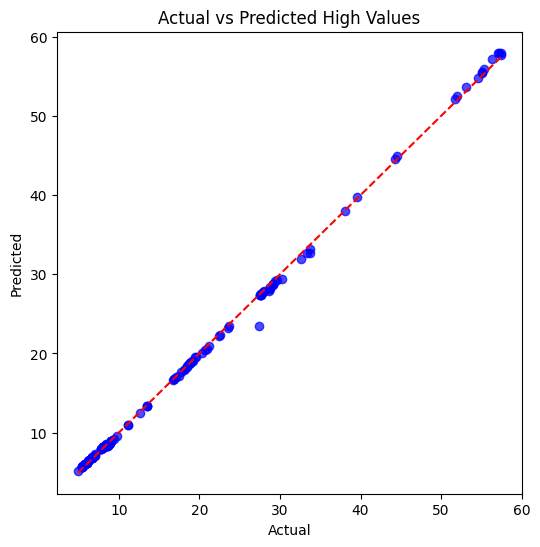

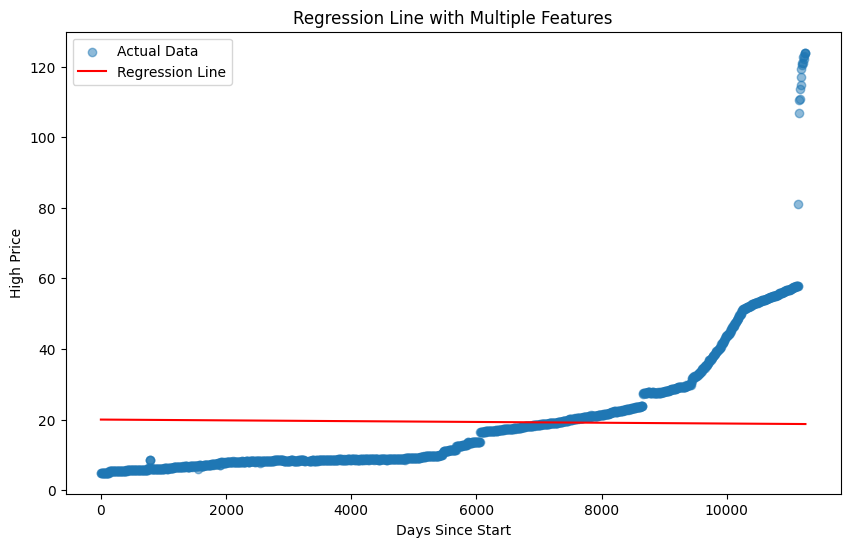

In [8]:
# Cell 7: Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted High Values")
plt.show()

days_range = np.linspace(features["Days"].min(), features["Days"].max(), 100).reshape(-1, 1)
mean_values = np.mean(features[["Open", "Low"]], axis=0).values.reshape(1, -1)
mean_values_repeated = np.repeat(mean_values, days_range.shape[0], axis=0)
high_pred_line = model.predict(np.hstack([days_range, mean_values_repeated]))

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(features["Days"], target, alpha=0.5, label="Actual Data")
plt.plot(days_range, high_pred_line, color="red", label="Regression Line")
plt.xlabel("Days Since Start")
plt.ylabel("High Price")
plt.title("Regression Line with Multiple Features")
plt.legend()
plt.show()


In [ ]:
# Cell 8: Prediction Interface
def predict_high(input_date):
    input_date = pd.to_datetime(input_date)
    days_since_start = (input_date - data_cleaned["Date"].min()).days
    closest_row = data_cleaned.iloc[(data_cleaned["Days"] - days_since_start).abs().argmin()]
    open_val = closest_row["Open"]
    low_val = closest_row["Low"]
    prediction = model.predict([[days_since_start, open_val, low_val]])[0]
    return prediction

input_date = input("Enter Date (YYYY-MM-DD): ")
predicted_high = predict_high(input_date)
print(f"Predicted High for {input_date}: {predicted_high}")